<a href="https://www.kaggle.com/code/lukalafaye/gan-mnist-dslab2?scriptVersionId=206610008" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import os
os.environ['PYTHON_PATH'] = "/kaggle/working/"

In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))


class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(SanDiscriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        
        # Self-attention inspired parameters
        self.attention_weights = nn.Parameter(torch.randn(1, self.fc3.out_features))

    def forward(self, x):
        # Extract features through fully connected layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
args = argparse.Namespace(batch_size=20)  # Set default value

print('Model Loading...')
# Model Pipeline
mnist_dim = 784

model = Generator(g_output_dim = mnist_dim).cuda()
model = load_model(model, '/kaggle/input/g/pytorch/v2/1/')
model = torch.nn.DataParallel(model).cuda()
model.eval()

print('Model loaded.')


print('Start Generating')
os.makedirs('samples', exist_ok=True)

image_paths = []

n_samples = 0
with torch.no_grad():
    while n_samples<10000:
        z = torch.randn(args.batch_size, 100).cuda()
        x = model(z)
        x = x.reshape(args.batch_size, 28, 28)
        for k in range(x.shape[0]):
            if n_samples<10000:
                image_path = os.path.join('samples', f'{n_samples}.png')
                torchvision.utils.save_image(x[k:k+1], image_path)         
                image_paths.append(image_path)  # Store image path
                n_samples += 1

In [ ]:
from IPython.display import display, Image

for img_path in image_paths[:50]:  # Slice to get only the first 10 images
    display(Image(filename=img_path))

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
import torch
import os
from tqdm import trange
import argparse
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from model import Generator, Discriminator
from utils import D_train, G_train, save_models
from IPython.display import display 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

parser = argparse.ArgumentParser(description='Train Normalizing Flow.')
parser.add_argument("--epochs", type=int, default=400, help="Number of epochs for training.")
parser.add_argument("--lr", type=float, default=0.0001, help="The learning rate to use for training.")
parser.add_argument("--batch_size", type=int, default=1024, help="Size of mini-batches for SGD")
args = parser.parse_args(args=[])

os.makedirs('checkpoints', exist_ok=True)
os.makedirs('data', exist_ok=True)

print('Dataset loading...')
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='data/MNIST/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/MNIST/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)
print('Dataset Loaded.')

print('Model Loading...')
mnist_dim = 784
G = torch.nn.DataParallel(Generator(g_output_dim=mnist_dim)).to(device)
D = torch.nn.DataParallel(Discriminator(mnist_dim)).to(device)
print('Model loaded.')

criterion = nn.BCELoss().to(device)
G_optimizer = optim.Adam(G.parameters(), lr=args.lr)
D_optimizer = optim.Adam(D.parameters(), lr=args.lr)

print('Start Training:')

def plot_generated_images(generator, epoch, num_images=20):
    """Function to plot and display generated images from the generator."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        generated_images = generator(noise)
        generated_images = generated_images.view(-1, 1, 28, 28).cpu()

        # Create two rows of 10 images
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))
        axes = axes.flatten()  # Flatten the axes array for easy iteration
        for ax, img in zip(axes, generated_images):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_losses(G_losses, D_losses):
    """Function to plot the losses over epochs."""
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.title("Generator and Discriminator Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Initialize lists to store the losses
G_losses = []
D_losses = []

n_epoch = args.epochs
for epoch in trange(1, n_epoch + 1, leave=True):
    print(epoch)
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, mnist_dim).to(device)
        
        D_loss, _, _ = D_train(x, G, D, D_optimizer, criterion)  # Capture only the first return value
        G_loss, _ = G_train(x, G, D, G_optimizer, criterion)  # Capture only the first return value

        # Accumulate the losses for the current epoch
        D_loss_epoch += D_loss
        G_loss_epoch += G_loss

    # Store the average loss per epoch
    D_losses.append(D_loss_epoch / len(train_loader))
    G_losses.append(G_loss_epoch / len(train_loader))

    print(f"Epoch [{epoch}/{n_epoch}], D Loss: {D_losses[-1]:.4f}, G Loss: {G_losses[-1]:.4f}")

    # Save models and generate images every 10 epochs
    if epoch % 10 == 0:
        save_models(G, D, 'checkpoints')
        plot_generated_images(G, epoch)

# After training, plot the losses
plot_losses(G_losses, D_losses)

print('Training done')

In [ ]:
!ls checkpoints

In [ ]:
def save_models(generator, discriminator, epoch, g_losses, d_losses, path='checkpoints'):
    checkpoint = {
        'epoch': epoch,
        'G_state_dict': generator.state_dict(),
        'D_state_dict': discriminator.state_dict(),
        'G_optimizer_state_dict': G_optimizer.state_dict(),
        'D_optimizer_state_dict': D_optimizer.state_dict(),
        'G_losses': g_losses,
        'D_losses': d_losses
    }
    torch.save(checkpoint, os.path.join(path, 'model_checkpoint.pth'))


In [ ]:
save_models(generator, discriminator, epoch, g_losses, d_losses)

In [ ]:
def load_checkpoint(generator, discriminator, g_optimizer, d_optimizer, path='checkpoints/model_checkpoint.pth'):
    checkpoint = torch.load(path)
    generator.load_state_dict(checkpoint['G_state_dict'])
    discriminator.load_state_dict(checkpoint['D_state_dict'])
    g_optimizer.load_state_dict(checkpoint['G_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['D_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    g_losses = checkpoint['G_losses']
    d_losses = checkpoint['D_losses']
    return start_epoch, g_losses, d_losses


In [ ]:
# Check if a checkpoint exists to resume from
checkpoint_path = 'checkpoints/model_checkpoint.pth'
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    start_epoch, G_losses, D_losses = load_checkpoint(G, D, G_optimizer, D_optimizer, checkpoint_path)
    print(f"Resuming from epoch {start_epoch}")

In [ ]:
n_epoch=30
for epoch in trange(1, n_epoch + 1, leave=True):
    print(epoch)
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, mnist_dim).to(device)
        
        D_loss, _, _ = D_train(x, G, D, D_optimizer, criterion)  # Capture only the first return value
        G_loss, _ = G_train(x, G, D, G_optimizer, criterion)  # Capture only the first return value

        # Accumulate the losses for the current epoch
        D_loss_epoch += D_loss
        G_loss_epoch += G_loss

    # Store the average loss per epoch
    D_losses.append(D_loss_epoch / len(train_loader))
    G_losses.append(G_loss_epoch / len(train_loader))

    print(f"Epoch [{epoch}/{n_epoch}], D Loss: {D_losses[-1]:.4f}, G Loss: {G_losses[-1]:.4f}")

    # Save models and generate images every 10 epochs
    if epoch % 10 == 0:
        save_models(G, D, 'checkpoints')
        plot_generated_images(G, epoch)

# After training, plot the losses
plot_losses(G_losses, D_losses)

print('Training done')

In [ ]:
torch.save(G.state_dict(), 'generator2.pth')

# SAN

In [ ]:
!pip install torch torchvision tqdm matplotlib

# Generator

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 

class Generator(nn.Module):
    def __init__(self, g_output_dim=784, dim_latent=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

# Discriminator

In [48]:
class BaseDiscriminator(nn.Module):
    def __init__(self, d_input_dim=784):
        super(BaseDiscriminator, self).__init__()
        self.h_function = nn.Sequential(
            nn.Linear(d_input_dim, 512),
            nn.LeakyReLU(0.2),
            #nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            #nn.Linear(256, 1)
        )

        self.fc_w = nn.Parameter(torch.randn(1, 256))

    def forward(self, x, flg_train: bool):        
        h_feature = self.h_function(x)
        weights = self.fc_w
        out = (h_feature * weights).sum(dim=1)
        return out

class SanDiscriminator(BaseDiscriminator):
    def __init__(self, d_input_dim=784):
        super(SanDiscriminator, self).__init__(d_input_dim)

    def forward(self, x, flg_train: bool):
        h_feature = self.h_function(x)        
        weights = self.fc_w
        direction = F.normalize(weights, dim=1)  # Normalize the last layer
        scale = torch.norm(weights, dim=1).unsqueeze(1)
        h_feature = h_feature * scale  # Keep the scale
        if flg_train:  # For discriminator training
            out_fun = (h_feature * direction.detach()).sum(dim=1)
            out_dir = (h_feature.detach() * direction).sum(dim=1)
            out = dict(fun=out_fun, dir=out_dir)
        else:  # For generator training or inference
            out = (h_feature * direction).sum(dim=1)
        return out


In [49]:
import argparse
import json
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

from torch.utils.data import DataLoader

In [50]:
import os
import json

# Define folder paths
mnist_folder = './data/MNIST'
logs_folder = './logs'
params_path = './hparams/params.json'

# Create folders if they don't exist
os.makedirs(mnist_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)
os.makedirs(os.path.dirname(params_path), exist_ok=True)

# Define the parameters for params.json
params = {
    "dim_latent": 100,
    "batch_size": 1024,
    "learning_rate_d": 0.0001,
    "learning_rate_g": 0.001,    
    "beta_1": 0.0,
    "beta_2": 0.99,
    "num_epochs": 200
}

# Write parameters to params.json
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Created folders '{mnist_folder}' and '{logs_folder}', and saved parameters to '{params_path}'.")


Created folders './data/MNIST' and './logs', and saved parameters to './hparams/params.json'.


In [51]:
default_args = {
    "datadir": "./data/MNIST",
    "params": "./hparams/params.json",
    "model": "san",
    "enable_class": False,
    "logdir": "./logs",
    "device": 0
}

In [52]:
from argparse import Namespace
args = Namespace(**default_args)

print(args.datadir)        # Access './data/MNIST'
print(args.params)         # Access './hparams/params.json'
print(args.model)          # Access 'gan'
print(args.enable_class)   # Access False
print(args.logdir)         # Access './logs'
print(args.device)         # Access 0

./data/MNIST
./hparams/params.json
san
False
./logs
0


In [53]:
# Train functions

def update_discriminator(x, discriminator, generator, optimizer, params):
    bs = x.size(0)
    device = x.device

    optimizer.zero_grad()

    # for data (ground-truth) distribution
    disc_real = discriminator(x, flg_train=True)
    loss_real = eval('compute_loss_'+args.model)(disc_real, loss_type='real')

    # for generator distribution
    latent = torch.randn(bs, params["dim_latent"], device=device)
    img_fake = generator(latent)
    disc_fake = discriminator(img_fake.detach(), flg_train=True)
    loss_fake = eval('compute_loss_'+args.model)(disc_fake, loss_type='fake')


    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer.step()
    
    return loss_real, loss_fake

def update_generator(discriminator, generator, optimizer, params, device):
    optimizer.zero_grad()

    bs = params['batch_size']
    latent = torch.randn(bs, params["dim_latent"], device=device)

    batch_fake = generator(latent)

    disc_gen = discriminator(batch_fake, flg_train=False)
    loss_g = - disc_gen.mean()
    loss_g.backward()
    optimizer.step()

    if torch.isnan(loss_g).any():
        print("NaN detected in generator loss!")
        return loss_g
    return loss_g
    

def compute_loss_gan(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss = (1. - disc).relu().mean() # Hinge loss
    else: # 'fake' == loss_type
        loss = (1. + disc).relu().mean() # Hinge loss

    return loss


def compute_loss_san(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss_fun = (1. - disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = - disc['dir'].mean() # Wasserstein loss for omega
    else: # 'fake' == loss_type
        loss_fun = (1. + disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = disc['dir'].mean() # Wasserstein loss for omega
    loss = loss_fun + loss_dir

    return loss


def save_images(imgs, idx, dirname='test'):
    # Ensure imgs is a numpy array if it's a tensor
    if isinstance(imgs, torch.Tensor):
        imgs = imgs.cpu().data.numpy()

    # If the images are grayscale (1 channel), repeat them to make them RGB (3 channels)
    if imgs.shape[1] == 1:  # This checks if there is only 1 channel (grayscale)
        imgs = np.repeat(imgs, 3, axis=1)  # Repeat the grayscale channel 3 times to make RGB

    # Create the output directory if it doesn't exist
    if not os.path.exists(f'out/{dirname}/'):
        os.makedirs(f'out/{dirname}/')

    # Set up the plot
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)

    # Loop through the batch of images
    for i, sample in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        # Ensure each sample has the shape (height, width, channels) for imshow
        sample = sample.transpose((1, 2, 0))  # Convert from (C, H, W) -> (H, W, C)

        # Plot the image
        plt.imshow(sample)

    # Save the plot to the directory
    plt.savefig(f'out/{dirname}/{str(idx).zfill(3)}.png', bbox_inches="tight")
    plt.close(fig)

def plot_generated_images(generator, epoch, num_images=20):
    """Function to plot and display generated images from the generator."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        generated_images = generator(noise)
        generated_images = generated_images.view(-1, 1, 28, 28).cpu()

        # Create two rows of 10 images
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))
        axes = axes.flatten()  # Flatten the axes array for easy iteration
        for ax, img in zip(axes, generated_images):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_losses(G_losses, D_real_losses, D_fake_losses):
    G_losses = [loss.detach().cpu().numpy() for loss in G_losses]
    D_real_losses = [loss.detach().cpu().numpy() for loss in D_real_losses]
    D_fake_losses = [loss.detach().cpu().numpy() for loss in D_fake_losses]
    
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_real_losses, label="Discriminator Real Loss")
    plt.plot(D_fake_losses, label="Discriminator Fake Loss")
    
    plt.title("Generator and Discriminator Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.ylim(-5, 5)
    plt.legend()
    plt.show()

san
hyperparameters: 
	dim_latent: 100
	batch_size: 1024
	learning_rate_d: 0.0001
	learning_rate_g: 0.001
	beta_1: 0.0
	beta_2: 0.99
	num_epochs: 200
epoch: 1/200


100%|██████████| 59/59 [00:05<00:00, 10.57it/s]


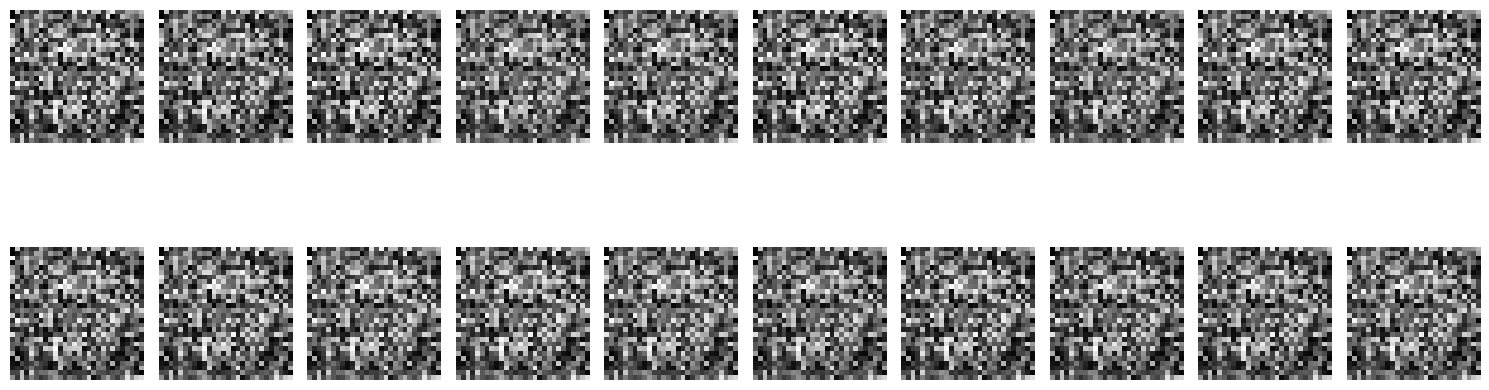

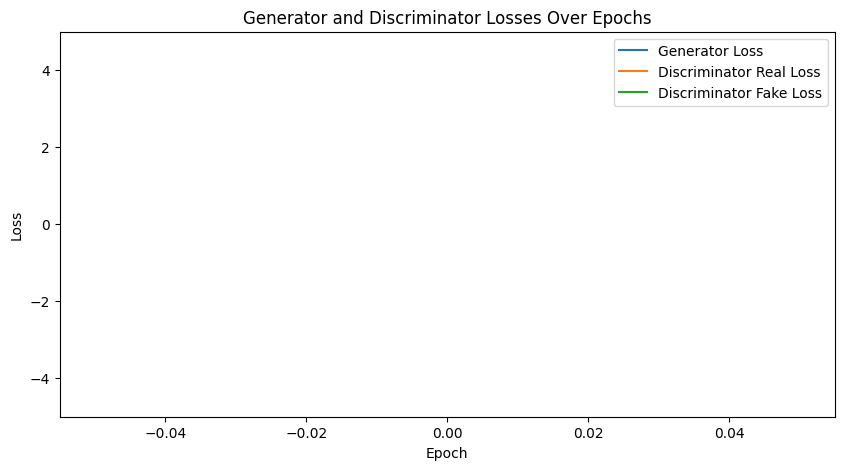

epoch: 2/200


 73%|███████▎  | 43/59 [00:04<00:01,  8.48it/s]

In [ ]:
device = f'cuda:{args.device}' if args.device is not None else 'cpu'
model_name = args.model
print(model_name)
if not model_name in ['gan', 'san']:
    raise RuntimeError("A model name have to be 'gan' or 'san'.")
    
experiment_name = model_name + "_cond" if args.enable_class else model_name

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

# dataloading
num_class = 10
train_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], num_workers=4,
                          pin_memory=True, persistent_workers=True, shuffle=True)

test_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], num_workers=4,
                         pin_memory=True, persistent_workers=True, shuffle=False)

# model
generator = Generator(g_output_dim=784)

if 'gan' == args.model:
    discriminator = BaseDiscriminator(d_input_dim=784)
else: # 'san' == args.model
    discriminator = SanDiscriminator(d_input_dim=784)
generator = generator.to(device)
discriminator = discriminator.to(device)

# optimizer
betas = (params["beta_1"], params["beta_2"])
optimizer_G = optim.Adam(generator.parameters(), lr=params["learning_rate_g"], betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=params["learning_rate_d"], betas=betas)

ckpt_dir = f'{args.logdir}/{experiment_name}/'
if not os.path.exists(args.logdir):
    os.mkdir(args.logdir)
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)

steps_per_epoch = len(train_loader)

msg = ["\t{0}: {1}".format(key, val) for key, val in params.items()]
print("hyperparameters: \n" + "\n".join(msg))

# eval initial states
num_samples_per_class = 10
with torch.no_grad():
    latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
    imgs_fake = generator(latent)


G_losses = []
D_real_losses = []
D_fake_losses = [] 

# main training loop
for n in range(params["num_epochs"]):
    loader = iter(train_loader)

    print("epoch: {0}/{1}".format(n + 1, params["num_epochs"]))
    G_loss_epoch = 0
    D_real_loss_epoch = 0
    D_fake_loss_epoch = 0

    for i in tqdm.trange(steps_per_epoch):
        x, class_ids = next(loader)
        x = x.to(device)
        x = x.view(x.size(0), -1)

        loss_real, loss_fake = update_discriminator(x, discriminator, generator, optimizer_D, params)
        G_loss = update_generator(discriminator, generator, optimizer_G, params, device)

        D_real_loss_epoch += loss_real
        D_fake_loss_epoch += loss_fake
        G_loss_epoch += G_loss


    # Store the average loss per epoch
    D_real_losses.append(D_real_loss_epoch / len(train_loader))
    D_fake_losses.append(D_fake_loss_epoch / len(train_loader))
    
    G_losses.append(G_loss_epoch / len(train_loader))
    

    plot_generated_images(generator, n+1)
    
    torch.save(generator.state_dict(), ckpt_dir + "g." + str(n) + ".tmp")
    torch.save(discriminator.state_dict(), ckpt_dir + "d." + str(n) + ".tmp")


    # eval
    with torch.no_grad():
        latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
        imgs_fake = generator(latent).cpu().data.numpy()
        imgs_fake = imgs_fake.reshape(-1, 1, 28, 28)
        save_images(imgs_fake, n, dirname=experiment_name)

    plot_losses(G_losses, D_real_losses, D_fake_losses)

torch.save(generator.state_dict(), ckpt_dir + "generator.pt")
torch.save(discriminator.state_dict(), ckpt_dir + "discriminator.pt")